In [121]:
! pip install tensornetwork

In [145]:
import tensornetwork as tn

import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

Tc = 2/np.log(1 + np.sqrt(2))
tn.set_default_backend("numpy")

In [146]:
def find_Z(beta, N=8):
    
    S = np.array([[np.exp(beta), np.exp(-beta)], [np.exp(-beta), np.exp(beta)]])
    S_root = sqrtm(S)
    T = np.einsum('ia,ib,ic,id->abcd', S_root, S_root, S_root, S_root)

    nodes = {}

    for i in range(N):
        for j in range(N):
            nodes[f'{i},{j}'] = tn.Node(name=f'{i},{j}', tensor=T,
                                       axis_names=['right', 'top',
                                                   'left', 'bottom'])
    for i in range(N):
        for j in range(N):
            # horizontal edges
            tn.connect(nodes[f'{i},{j}'].get_edge(0),
                       nodes[f'{(i+1)%N},{j}'].get_edge(2))
            #vertical edges
            tn.connect(nodes[f'{i},{j}'].get_edge(1),
                       nodes[f'{i},{(j+1)%N}'].get_edge(3))
            
    Z = tn.contractors.auto(list(nodes.values()))
    
    return Z.tensor.item()

  0%|          | 0/32 [00:00<?, ?it/s]

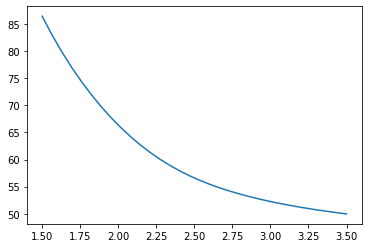

In [147]:
N = 8

Ts = np.linspace(1.5, 3.5, 32) # Tc ~ 2.5 for N = Infinity lattice.
betas = 1/Ts
# betas = np.linspace(0.25, 1, 32)

Zs = []

for beta in tqdm(betas):
    Z = find_Z(beta, N)
    Zs.append(Z)
    
plt.plot(Ts, np.log(Zs));


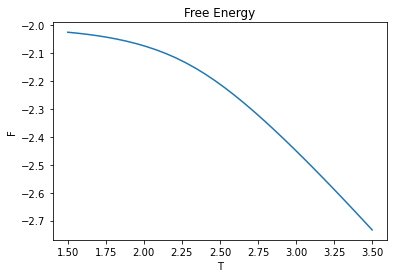

In [156]:
Fs = -Ts * ln_Z/ (N**2)
plt.plot(Ts, Fs);
plt.title('Free Energy');
plt.xlabel('T');
plt.ylabel('F');
plt.savefig('Free energy.jpg')

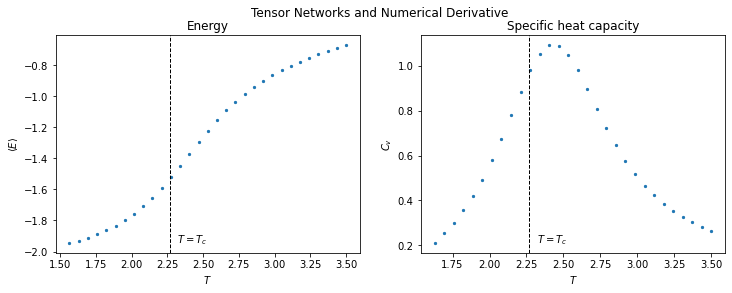

In [150]:

# Energy
dln_Z_d = [(ln_Z[i+1]-ln_Z[i])/(betas[i+1]-betas[i])
                 for i in range(ln_Z.shape[0]-1)]
dln_Z_d = np.array(dln_Z_d)/N**2
E = -dln_Z_d

# Specific heat
dln_Z_d2 = [(dln_Z_d[i+1]-dln_Z_d[i])/(betas[i+1]-betas[i])
           for i in range(dln_Z_d.shape[0]-1)]
dln_Z_d2 = np.array(dln_Z_d2)
Delta_E2 = dln_Z_d2
C =  Delta_E2/Ts[2:]**2

Ts = 1/betas

f = plt.figure(figsize=(12, 4)); #  

f.add_subplot(1,2,1);
plt.scatter(Ts[1:], E, s=5)
plt.axvline(x=Tc, c='k', linewidth=1, linestyle='--')
plt.annotate(r'$T = T_c$', xy=(Tc+0.05,np.min(E)), fontsize=10);
plt.xlabel(r'$ T $')
plt.ylabel(r'$ \langle E \rangle $');
plt.title('Energy');

f.add_subplot(1,2,2);
plt.scatter(Ts[2:], C, s=5)
plt.axvline(x=Tc, c='k', linewidth=1, linestyle='--')
plt.annotate(r'$T = T_c$', xy=(Tc+0.05,np.min(C)), fontsize=10);
plt.xlabel(r'$ T $')
plt.ylabel(r'$ C_{v} $');
plt.title('Specific heat capacity');

plt.suptitle('Tensor Networks and Numerical Derivative');
plt.savefig('TN E and C.jpg')